In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax.numpy as jnp
import jax
from functools import partial, wraps
from scipy.special import erf
import scipy

In [2]:
import lib

In [3]:
class Neuron10_2_Y(lib.Neuron10_2):
    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) - self.b # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)
        updated_w = w[updated_idx] + jnp.heaviside(self.kappa-updated_overlap, 0.).reshape((-1, 1))*(x[updated_idx]*(self.kappa-updated_overlap).reshape((-1, 1)) - self.beta*w[updated_idx])/self.ns # dim = (ndR, ns)
        latent_var = updated_idx
        return w.at[updated_idx].set(updated_w), latent_var
    
class Neuron11_2_Y(lib.Neuron11_2):
    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)
        updated_w = w[updated_idx] + jnp.heaviside(self.kappa+self.b-updated_overlap, 0.).reshape((-1, 1))*(x[updated_idx]*(self.kappa+self.b-(1-self.beta/self.ns)*updated_overlap).reshape((-1, 1)) - self.beta*w[updated_idx])/self.ns # dim = (ndR, ns)
        latent_var = updated_idx
        return w.at[updated_idx].set(updated_w), latent_var
    
class Neuron11_2_2_Y(lib.Neuron11_2):
    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) # dim = (nd, )
        x_parallel = overlaps / jnp.linalg.norm(w, axis=-1)
        _, updated_idx = jax.lax.top_k(x_parallel, self.ndR)
        updated_overlap = overlaps[updated_idx]
        updated_w = w[updated_idx] + jnp.heaviside(self.kappa+self.b-updated_overlap, 0.).reshape((-1, 1))*(x[updated_idx]*(self.kappa+self.b-(1-self.beta/self.ns)*updated_overlap).reshape((-1, 1)) - self.beta*w[updated_idx])/self.ns # dim = (ndR, ns)
        latent_var = updated_idx
        return w.at[updated_idx].set(updated_w), latent_var

class Neuron3_2_Y(lib.Neuron3_2):
    @wraps(partial(jax.jit, static_argnums=(0, )))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) - self.b # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)
        updated_w = w[updated_idx] + jax.nn.relu(self.kappa - updated_overlap).reshape((-1, 1))*x[updated_idx]/self.ns # dim = (ndR, ns)
        updated_w = updated_w/jnp.linalg.norm(updated_w, ord=2, axis=-1, keepdims=True)
        latent_var = updated_idx
        return w.at[updated_idx].set(updated_w), latent_var

class Simulation_Run_Y_distribution():
    def __init__(self, neuron: Neuron11_2_Y, xs_gen: lib.Xs_Generator, decay_steps=500, initial_steps=500, n_tested_patterns=100, refresh_every=1000, seed=42) -> None:
        self.key = jax.random.PRNGKey(seed)
        self.key, subkey1, subkey2 = jax.random.split(self.key, 3)
        self.neuron = neuron
        self.decay_steps = decay_steps
        self.initial_steps = initial_steps
        self.n_test_patterns = n_tested_patterns
        self.refresh_every = max(refresh_every, n_tested_patterns)
        self.xs_gen = xs_gen
        self.xs = self.xs_gen.gen(subkey1, self.refresh_every)
        self.init_w(subkey2)

        self.overlaps_record = np.zeros((n_tested_patterns, self.neuron.nd))
        self.updated_idx_record = np.zeros((n_tested_patterns, self.neuron.ndR))

    @partial(jax.jit, static_argnums=(0, ))
    def neuron_update_fun(self, w, x, latent_var):
        return self.neuron.update_fun(w, x, latent_var)

    def init_w(self, key):
        for i  in range(self.initial_steps):
            if i%self.refresh_every == 0:
                subkey, key = jax.random.split(key)
                xs0 = self.xs_gen.gen(subkey, self.refresh_every)
            self.neuron.w, self.neuron.latent_var = self.neuron_update_fun(self.neuron.w, xs0[i%self.refresh_every], self.neuron.latent_var)

    @partial(jax.jit, static_argnums=(0, ))
    def _update(self, w, latent_var, x):
        w, latent_var = self.neuron_update_fun(w, x, latent_var)
        # votes = jax.vmap(self.neuron.get_votes, in_axes=(None, 0))(w, x0s) # dim=(n_tested_patterns, )
        return w, latent_var

    def run(self, t, progress_bar=True):
        self.key, subkey = jax.random.split(self.key)
        self.xs = self.xs_gen.gen(subkey, self.refresh_every)        
        x0s = self.xs[:self.n_test_patterns] # in jax numpy, a copy is created for x0s
        if progress_bar is True: 
            pb = tqdm(range(t+self.n_test_patterns))
        else:
            pb = range(t+self.n_test_patterns)
        for i in pb:
            if i%self.refresh_every == 0 and i>=self.refresh_every:
                self.key, subkey = jax.random.split(self.key)
                self.xs = self.xs_gen.gen(subkey, self.refresh_every)
            self.neuron.w, self.neuron.latent_var = self._update(self.neuron.w, self.neuron.latent_var, self.xs[i%self.refresh_every])
            if i >= t:
                idx_tmp = i-t
                overlaps = np.sum(self.neuron.w*x0s[idx_tmp], axis=-1) # dim = (nd, )
                self.overlaps_record[idx_tmp] = overlaps
            if i < self.n_test_patterns:
                self.updated_idx_record[i] = self.neuron.latent_var

In [4]:
n_iterations = 30
t=1200

ns=300
nd=200
rho = 1
bias = 2.75
ndR = 4
kappa = 2.25
n_votes = nd
vote_th = bias
# la = 0.445556
beta = 10.0242

decay_steps = 2000
n_tested_patterns = 4000
initial_steps = 5000

expzI_records = np.zeros((n_iterations))
expz2I_records = np.zeros((n_iterations))
expaI_records = np.zeros((n_iterations))
expzII_records = np.zeros((n_iterations))
expz2II_records = np.zeros((n_iterations))
expaII_records = np.zeros((n_iterations))
YI_records = np.zeros((n_iterations, n_tested_patterns))
YII_records = np.zeros((n_iterations, n_tested_patterns))

seed = 1029
rng = np.random.default_rng(seed)

neuron2 = Neuron11_2_Y(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, ndR=ndR, beta=beta, vote_th=vote_th, seed=rng.integers(100000))
xs_gen = lib.Xs_Generator3_2(nd, ns, rho, normalized_len=np.sqrt(ns), seed=rng.integers(100000))
simulation_run2 = Simulation_Run_Y_distribution(neuron2, xs_gen, decay_steps=decay_steps, initial_steps=initial_steps, n_tested_patterns=n_tested_patterns, refresh_every=500, seed=rng.integers(100000))


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
for i in range(n_iterations):
    simulation_run2.run(t=t)
    
    tmp = np.ones((n_tested_patterns, 1), dtype=int)*np.arange(nd, dtype=int)
    tmpII = simulation_run2.updated_idx_record.astype(int)
    tmpI = np.array([np.setdiff1d(tmp[i], tmpII[i], assume_unique=True) for i in range(n_tested_patterns)])
    uII_record = simulation_run2.overlaps_record[np.arange(n_tested_patterns, dtype=int).reshape((-1, 1))*np.ones(ndR, dtype=int), tmpII]
    uI_record = simulation_run2.overlaps_record[np.arange(n_tested_patterns, dtype=int).reshape((-1, 1))*np.ones(nd-ndR, dtype=int), tmpI]
    zI_record = (uI_record - bias)*(uI_record - bias > 0)
    zII_record = (uII_record - bias)*(uII_record - bias > 0)
    YI_records[i] = np.sum(zI_record, axis=-1)
    YII_records[i] = np.sum(zII_record, axis=-1)
    expzI_records[i] = np.mean(zI_record)
    expzII_records[i] = np.mean(zII_record)
    expz2I_records[i] = np.mean(zI_record**2)
    expz2II_records[i] = np.mean(zII_record**2)
    expaI_records[i] = 1 - np.nonzero(zI_record.reshape((-1, )))[0].shape[0] / len(zI_record.reshape((-1, )))
    expaII_records[i] = 1 - np.nonzero(zII_record.reshape((-1, )))[0].shape[0] / len(zII_record.reshape((-1, )))

100%|██████████| 5200/5200 [00:11<00:00, 461.34it/s] 


In [6]:
expzI = np.mean(expzI_records)
expzII = np.mean(expzII_records)
expz2I = np.mean(expz2I_records)
expz2II = np.mean(expz2II_records)
expaI = np.mean(expaI_records)
expaII = np.mean(expaII_records)
YI_records = YI_records.reshape((-1, ))
YII_records = YII_records.reshape((-1, ))
Y_records = YI_records + YII_records
expYI = np.mean(YI_records)
expYII = np.mean(YII_records)
expY = np.mean(Y_records)
expY2I = np.mean(YI_records**2)
expY2II = np.mean(YII_records**2)
expY2 = np.mean(Y_records**2)
expAI = 1 - np.nonzero(YI_records)[0].shape[0] / len(YI_records)
expAII = 1 - np.nonzero(YII_records)[0].shape[0] / len(YII_records)


print("---------------------")
print("<zI>: ", expzI)
print("<zII>: ", expzII)
print("<zI^2>-<zI>^2: ", expz2I-expzI**2, "   <zI^2>: ", expz2I)
print("<zII^2>-<zII>^2: ", expz2II-expzII**2, "   <zII^2>: ", expz2II)
print("<aI>: ", expaI)
print("<aII>: ", expaII)
print("---------------------")
print("<YI>: ", expYI)
print("<YII>: ", expYII)
print("<Y>: ", expY)
print("<YI^2> - <YI>^2: ", expY2I - expYI**2, "   <YI^2>: ", expY2I)
print("<YII^2> - <YII>^2: ", expY2II - expYII**2, "   <YII^2>: ", expY2II)
print("<Y^2>-<Y>^2: ", expY2-expY**2, "   <Y^2>: ", expY2)
print("<AI>: ", expAI)
print("<AII>: ", expAII)

---------------------
<zI>:  0.000272805004267871
<zII>:  0.9901076783165337
<zI^2>-<zI>^2:  0.00011542088951924583    <zI^2>:  0.00011549531208959943
<zII^2>-<zII>^2:  0.39706019502831735    <zII^2>:  1.377373409689674
<aI>:  0.9988098214285714
<aII>:  0.08452291666666668
---------------------
<YI>:  0.05346978083650271
<YII>:  3.9604307132661343
<Y>:  4.013900494102637
<YI^2> - <YI>^2:  0.023021736987352888    <YI^2>:  0.02588075445005652
<YII^2> - <YII>^2:  1.591380030280808    <YII^2>:  17.27639146486251
<Y^2>-<Y>^2:  1.6160866966336407    <Y^2>:  17.72748387319103
<AI>:  0.7939333333333334
<AII>:  5.833333333338242e-05


In [7]:
expzI = np.mean(expzI_records)
expzII = np.mean(expzII_records)
expz2I = np.mean(expz2I_records)
expz2II = np.mean(expz2II_records)
expaI = np.mean(expaI_records)
expaII = np.mean(expaII_records)
YI_records = YI_records.reshape((-1, ))
YII_records = YII_records.reshape((-1, ))
Y_records = YI_records + YII_records
expYI = np.mean(YI_records)
expYII = np.mean(YII_records)
expY = np.mean(Y_records)
expY2I = np.mean(YI_records**2)
expY2II = np.mean(YII_records**2)
expY2 = np.mean(Y_records**2)
expAI = 1 - np.nonzero(YI_records)[0].shape[0] / len(YI_records)
expAII = 1 - np.nonzero(YII_records)[0].shape[0] / len(YII_records)


print("---------------------")
print("<zI>: ", expzI)
print("<zII>: ", expzII)
print("<zI^2>-<zI>^2: ", expz2I-expzI**2, "   <zI^2>: ", expz2I)
print("<zII^2>-<zII>^2: ", expz2II-expzII**2, "   <zII^2>: ", expz2II)
print("<aI>: ", expaI)
print("<aII>: ", expaII)
print("---------------------")
print("<YI>: ", expYI)
print("<YII>: ", expYII)
print("<Y>: ", expY)
print("<YI^2> - <YI>^2: ", expY2I - expYI**2, "   <YI^2>: ", expY2I)
print("<YII^2> - <YII>^2: ", expY2II - expYII**2, "   <YII^2>: ", expY2II)
print("<Y^2>-<Y>^2: ", expY2-expY**2, "   <Y^2>: ", expY2)
print("<AI>: ", expAI)
print("<AII>: ", expAII)

---------------------
<zI>:  0.000272805004267871
<zII>:  0.9901076783165337
<zI^2>-<zI>^2:  0.00011542088951924583    <zI^2>:  0.00011549531208959943
<zII^2>-<zII>^2:  0.39706019502831735    <zII^2>:  1.377373409689674
<aI>:  0.9988098214285714
<aII>:  0.08452291666666668
---------------------
<YI>:  0.05346978083650271
<YII>:  3.9604307132661343
<Y>:  4.013900494102637
<YI^2> - <YI>^2:  0.023021736987352888    <YI^2>:  0.02588075445005652
<YII^2> - <YII>^2:  1.591380030280808    <YII^2>:  17.27639146486251
<Y^2>-<Y>^2:  1.6160866966336407    <Y^2>:  17.72748387319103
<AI>:  0.7939333333333334
<AII>:  5.833333333338242e-05


In [17]:
theory_YII = np.genfromtxt("tmp_data/tmpList.csv", delimiter=',')

(0.0, 0.05)

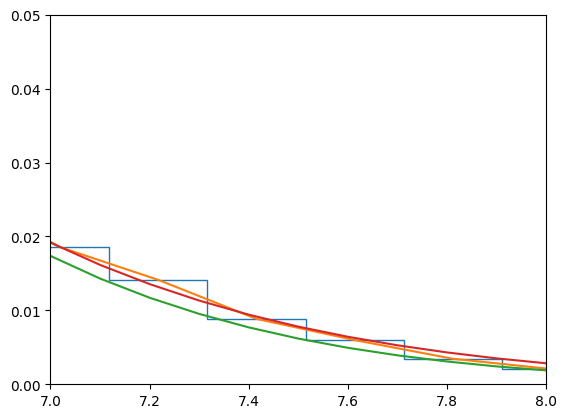

In [22]:
ys, xs, _ = plt.hist(YII_records, bins=50, density=True, histtype="step", cumulative=False)
xs = (xs[:-1]+xs[1:])/2
plt.plot(xs, ys)
def tmpfun(y, a, mu, sigma):
    return (1-a)*np.exp(-(y-mu)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2)/0.5/(1+erf(mu/sigma/np.sqrt(2.)))
def tmpfunCum(y, a, mu, sigma):
    return a + (1-a)*(erf((y-mu)/sigma/np.sqrt(2))+erf(mu/sigma/np.sqrt(2.)))/(1+erf(mu/sigma/np.sqrt(2.)))
# plt.plot(np.arange(0, 10, 0.1), tmpfun(np.arange(0, 10, 0.1), 0.000025, 4.19078, 1.26685))
plt.plot(np.arange(0, 10, 0.1), tmpfun(np.arange(0, 10, 0.1), 0.0000, np.mean(YII_records), np.std(YII_records)))
plt.plot(theory_YII[:, 0], theory_YII[:, 1], label="skew gaussian")
plt.xlim(7, 8)
# plt.xlim(0, 2)
plt.ylim(0, 0.05)

In [10]:
np.mean(YII_records)

3.9604307132661343

(0.0, 0.2)

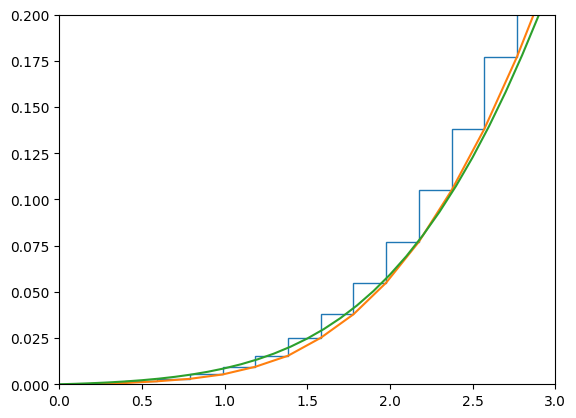

In [11]:
ys, xs, _ = plt.hist(YII_records, bins=50, density=True, histtype="step", cumulative=True);
plt.plot(xs[1:], ys)
def tmpfun(y, a, mu, sigma):
    return (1-a)*np.exp(-(y-mu)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2)/0.5/(1+erf(mu/sigma/np.sqrt(2.)))
def tmpfunCum(y, a, mu, sigma):
    return a + (1-a)*(erf((y-mu)/sigma/np.sqrt(2))+erf(mu/sigma/np.sqrt(2.)))/(1+erf(mu/sigma/np.sqrt(2.)))
# plt.plot(np.arange(0, 10, 0.1), tmpfunCum(np.arange(0, 10, 0.1), 0.000025, 4.19078, 1.26685))
plt.plot(np.arange(0, 10, 0.1), tmpfunCum(np.arange(0, 10, 0.1), 0.0000, np.mean(YII_records), np.std(YII_records)))
plt.xlim(0, 3)
plt.ylim(0, 0.2)

In [9]:
np.mean(YII_records)
np.std(YII_records)
scipy.stats.skew(YII_records)

0.10206573645654211

In [ ]:
0.0951717

(0.0, 1.0)

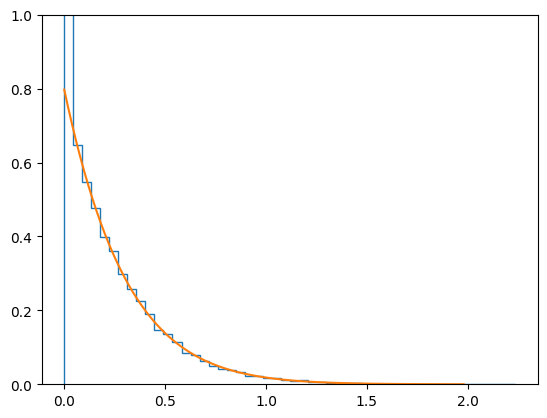

In [8]:
plt.hist(YI_records, bins=50, density=True, histtype="step");
# def tmpfun(y, a, mu, sigma):
#     return (1-a)*np.exp(-(y-mu)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2)/0.5/(1+erf(mu/sigma/np.sqrt(2.)))
plt.plot(np.arange(0, 2, 0.02), tmpfun(np.arange(0, 2, 0.02), 0.773475, -2.94779, 0.955477))
plt.ylim(0, 1.)

In [36]:
np.sum(YII_records<2.)/len(YII_records)

0.038266666666666664

In [10]:
np.sum(YI_records>0.1)/len(YI_records)

0.158875

In [19]:
xs_tmp = xs_gen.gen(key=jax.random.PRNGKey(123), n_patterns=30)

In [21]:
tmp = np.sum(xs_tmp*neuron2.w, axis=-1).reshape((-1, ))
np.sum(tmp>bias)

Array(21, dtype=int32)

In [25]:
np.sum(Y_records < 1.41071)/len(Y_records)

0.015208333333333334